In [269]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm
import matplotlib.gridspec as gridspec
from factanal.wrapper import factanal
import json
import seaborn as sns

import geopandas as gp
import descartes
# import geoplot

# import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.decomposition import non_negative_factorization, NMF
from matplotlib.ticker import PercentFormatter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [270]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [271]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [272]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
       
def perform_fa(df, NUM, rotation, scores_method, method):
    
    fa = factanal(df, factors=NUM, scores=scores_method, rotation=rotation,  #'Bartlett','regression'
                  verbose=True, return_dict=True)
    
#     fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
#     fa.fit(df)
    return fa


def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    print(stations['factor'].unique())
    df.plot(ax=ax,c=stations['factor'])
    plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/map_3_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load, list_of_factors, station_names, weekend_removed, to_save):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)

    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left
    
    # don't include the weekend in the plot
    df_scores[df_scores['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
    ax4.legend(bbox_to_anchor=(1.7, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,len(station_names)))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();
    
    plt.rcParams.update({'font.size': 14})
    fig.tight_layout()
    if to_save:
        plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/change_name.png", dpi=500)
    
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
  
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
#     print(df_scores['week day'].unique())
    df_scores.loc[df_scores['week day']==7,'week day']=0
#     print(df_scores['week day'].unique())
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times,weekend_removed):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
#     plt.ylim([-100,100])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df[df['week day'].isin([0,1,2,3,4])].groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')

    fig.tight_layout()
    plt.show();
    
    
    
def get_FA_results(df, times,  NUM, rotation, gdf, weekend_removed, show_factors, to_save, scores_method):

    mpl.style.use('default')
#     print(test_if_FA_suitable(df))
    
#     # scree plot
#     fa = FactorAnalyzer()
#     fa.fit(df)
#     ev, _ = fa.get_eigenvalues()
#     scree_plot(ev,df)
    
#     df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
    
    # FA
    fa = perform_fa(df, NUM, rotation, scores_method, method = 'ml')
    
#     # print cummulative variance
#     print(fa.get_factor_variance())

    # print uniqueneses
#     print(fa['uniquenesses'])
    
    # plot loadings 
#     # with factorAnalyzer()
#     Loadings = fa.loadings_
#     scores = fa.transform(df) # numerical value, no units

    # with factanal (R)
    Loadings = np.array(fa['loadings'])
    scores = np.array(fa['scores']) # numerical value, no units
    rotmat = []
#     if rotation == 'none':
#         rotmat = []
#     else: 
#         rotmat = np.array(fa['rotmat'])
    
    col_names = df.columns
#     loadings_plot(Loadings, col_names)
    
#     # plot stations  
#     # ascribe a factor to each station based on max loading value (and show it on map)
#     stations = stations[stations.name.isin(df.columns)]
#     stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
#     stations['max_load'] = np.max(abs(Loadings),axis=1)
#     plot_map(gdf,stations)
    
    # plot factors and loadings 
    FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
    
    if (show_factors == 'all'): 
        list_of_factors = FACTOR_COLUMNS      
#         print('Hi')
    else:
        list_of_factors = show_factors
        
    
    df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
    df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)
#     print(df_scores.index)
#     print(times.index)
    df_scores = add_group_columns_to_df_scores(df_scores,times)
#     print(df_scores.head())
#     print(df_scores['week day'].unique())


#     # UNSTANDARDIZE FACTORS
#     for i in range(NUM):
#         df_scores.iloc[:,i] = df.mean(axis=1) + df.std(axis=1)*df_scores.iloc[:,i].values
    
    plot_factors_and_loadings(df_scores,df_load, list_of_factors, df.columns, weekend_removed, to_save)
    plt.rcParams.update({'font.size': 14})
    
    return rotmat, Loadings, scores



In [273]:
def initialize():
#     df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1_fixed_2012_2019.csv")
#     times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df_2012_2019.csv")
    times = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/times_df_2012_2019.csv")
#     df = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/RF_add1_fixed_2012_2019.csv")
    df = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/final_imputed_df_mix")
    
    to_keep = ['ANTOKOLSKY', 'HOLON', 'IRONID', 'KVISH4', 'PETAH_TIKVA_ROAD', 'REMEZ',
       'YAD_LEBANIM', 'YEFET_YAFO', 'AHUZA_G', 'ATZMAUT_B', 'KAKAL',
       'KIRYAT_ATA', 'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON',
       'NAVE_SHANAAN', 'NESHER', 'BAR_ILAN', 'EFRATA', 'NAVE_ILAN',
       'ASHDOD_IGUD', 'ASHKELON_SOUTH', 'DALYA', 'GEDERA', 'GVARAAM',
       'KIRYAT_MALAHI', 'NIR_ISRAEL', 'ORT', 'ROVA_TV', 'SDEROT', 'SDE_YOAV',
       'YAHALOM', 'BEER_SHEVA', 'EAST_NEGEV', 'KFAR_MASARIK', 'HEFZIBA',
       'PARDES_HANA', 'RAANANA']  
    
    df = df.loc[:,df.columns.isin(to_keep)]
    
#     df.drop(columns = 'Unnamed: 0',inplace=True)
    times.drop(columns = 'Unnamed: 0',inplace=True)
    times.rename({'0': 'time'}, axis = 'columns',inplace=True)
    
    # NOTE THIS STATION FILE WAS GENERATED FOR 34 STATIONS OF 2013-2018
#     stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 
#     gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
#     stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info.csv") 
    gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

    return df,times,gdf

# GENERATE a sub-df of PM25

In [432]:
remove_weekends = False
# chosen_months = [5,6,7]
# chosen_months = [11,12,1,2]
chosen_months = [1,2,3,4,5,6,7,8,9,10,11,12]

In [433]:
# initialize to get times:
df,times,gdf = initialize()

# choose the type of data I want to FA (i.e., REMOVE STATIONS/EXTREME EVENTS...)

# # extreme events/only the dust storm
# pm_threshold = 600000

# # remove dust storms in 2015 and 100
# time_condition = [(((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))
# #                   | ((times.time>='2017-01-01 00:00:00'))
# #                   | ((times.time>='2015-01-06 07:30:00') & (times.time<='2015-01-08 10:00:00'))
#                   | ((df.values > pm_threshold).any(axis=1))
#                   )]

# idx_to_drop = np.argwhere(time_condition)[:,1]
# df.drop(idx_to_drop,axis = 0, inplace=True)
# times.drop(idx_to_drop,axis = 0, inplace=True)


# choose months
df['month'] = pd.to_datetime(times['time']).dt.month
times = times[df.month.isin(chosen_months)]
df = df[df.month.isin(chosen_months)]
df.drop(['month'],axis = 1, inplace =True)
# reset index!
df.reset_index(inplace=True)
df.drop(labels = 'index',axis=1, inplace=True)
times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

# remove stations
STATIONS_TO_INCLUDE = ['ATZMAUT_B','KIRYAT_BIALIK']

# df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
df = df[STATIONS_TO_INCLUDE]

# RESET INDEX!!!!
times.reset_index(inplace=True,drop=True)
df.reset_index(inplace=True,drop=True)

In [435]:
# starting in 2017
ind_to_start = np.argwhere(np.array([times.time == '2017-01-01 00:30:00']))[0][1]

In [ ]:
df = df.iloc[ind_to_start:,]

In [438]:
df.reset_index(inplace=True,drop=True)

# impute NOx series

In [277]:
df_nox = pd.read_pickle('~/Documents/Broday/saved_data_from_notebooks/df_nox_NMF')

In [278]:
df_nox.isnull().sum()/df_nox.shape[0]

ANTOKOLSKY          0.167151
HOLON               0.067398
IRONID              0.073102
KVISH4              0.208326
PETAH_TIKVA_ROAD    0.075947
REMEZ               0.082278
YAD_LEBANIM         1.000000
YEFET_YAFO          0.128601
AHUZA_G             0.297770
ATZMAUT_B           0.078421
KAKAL               0.492884
KIRYAT_ATA          0.044896
KIRYAT_BIALIK       0.720746
KIRYAT_BINYAMIN     0.439924
KIRYAT_TIVON        0.289556
NAVE_SHANAAN        0.289364
NESHER              0.289635
BAR_ILAN            0.063983
EFRATA              0.073459
NAVE_ILAN           0.736881
ASHDOD_IGUD         0.093529
ASHKELON_SOUTH      0.139851
DALYA               0.444280
GEDERA              0.222158
GVARAAM             0.078207
KIRYAT_MALAHI       0.064995
NIR_ISRAEL          0.078820
ORT                 1.000000
ROVA_TV             0.491886
SDEROT              0.147010
SDE_YOAV            0.067284
YAHALOM             1.000000
BEER_SHEVA          0.116879
EAST_NEGEV          0.260866
KFAR_MASARIK  

In [279]:
df_nox.drop(labels = ['HEFZIBA','ORT','YAHALOM','YAD_LEBANIM'],axis=1, inplace=True)

In [280]:
df_nox.reset_index(drop=True,inplace=True)

In [281]:
df_nox

,ANTOKOLSKY,HOLON,IRONID,KVISH4,PETAH_TIKVA_ROAD,REMEZ,YEFET_YAFO,AHUZA_G,ATZMAUT_B,KAKAL,...,KIRYAT_MALAHI,NIR_ISRAEL,ROVA_TV,SDEROT,SDE_YOAV,BEER_SHEVA,EAST_NEGEV,KFAR_MASARIK,PARDES_HANA,RAANANA
0,33.0,14.8,45.8,42.8,103.0,39.7,88.2,NaN,105.0,8.7,...,7.7,6.1,6.7,7.7,3.3,14.1,NaN,NaN,6.0,42.5
1,30.2,12.1,36.8,39.9,94.4,40.9,77.4,NaN,129.4,8.9,...,6.9,6.7,4.0,5.9,NaN,10.8,NaN,NaN,4.7,40.5
2,NaN,10.2,34.4,36.0,75.1,31.5,70.7,NaN,165.5,8.1,...,6.8,6.5,4.9,6.1,NaN,8.6,NaN,NaN,3.5,45.1
3,27.5,9.9,32.0,32.7,67.6,36.7,53.7,NaN,119.2,7.1,...,7.4,5.5,1.8,6.0,4.2,8.6,NaN,NaN,2.7,NaN
4,25.2,8.2,32.8,36.3,70.9,31.9,24.5,NaN,129.3,7.0,...,8.9,5.1,NaN,5.6,4.3,7.0,NaN,NaN,2.9,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,60.8,39.0,55.8,21.7,81.0,45.0,102.4,10.4,159.2,NaN,...,16.8,27.8,NaN,12.0,13.7,126.3,15.5,14.6,23.5,46.0
140252,55.4,33.4,47.7,17.1,75.4,38.6,98.9,15.0,99.2,NaN,...,18.3,20.2,NaN,12.8,12.3,83.2,14.9,13.9,18.2,41.4
140253,45.4,31.9,39.2,13.3,55.9,34.3,84.1,14.1,176.9,NaN,...,14.0,15.2,NaN,13.9,13.6,46.7,17.0,16.4,17.1,44.2
140254,48.5,29.8,33.2,10.8,60.0,45.5,87.8,13.0,174.5,NaN,...,11.8,12.3,NaN,14.7,11.9,44.5,8.7,16.7,15.7,42.1


In [282]:
num_iter = 2
rnd_state_forRF = 0 
n_estimators = 10

In [284]:
# imp = IterativeImputer(max_iter=num_iter,estimator=ExtraTreesRegressor(n_estimators=n_estimators,
#                                                          random_state=rnd_state_forRF,
#                                                          n_jobs=-1
#                                                         ),verbose=True) 
# imp.fit(df_nox.values)
# imputed = imp.transform(df_nox.values) 

In [285]:
# imputed.shape

In [20]:
# df_nox = pd.DataFrame(imputed,columns = df_nox.columns)

In [21]:
# df_nox.to_pickle('~/Documents/Broday/saved_data_from_notebooks/df_nox_NMF_imputed')

# GENERATE a sub-df of NOx and concat to PM2.5

In [440]:
# starting in 2017
ind_to_start = np.argwhere(np.array([times.time == '2017-01-01 00:30:00']))[0][1]

In [441]:
df_nox = pd.read_pickle('~/Documents/Broday/saved_data_from_notebooks/df_nox_imputed')

In [442]:
df_nox = df_nox.loc[ind_to_start:,STATIONS_TO_INCLUDE]

In [443]:
df_nox.reset_index(inplace=True,drop=True)

In [444]:
nox_columns = df_nox.columns
nox_columns = [i+'_NOx' for i in nox_columns.values]

In [445]:
df_nox.columns = nox_columns

In [446]:
df_nox.head(1)

,ATZMAUT_B_NOx,KIRYAT_BIALIK_NOx
0,76.2,12.5


In [447]:
pm_columns = df.columns
pm_columns = [i+'_PM25' for i in pm_columns.values]

In [448]:
df.columns = pm_columns

In [449]:
df.head(1)

,ATZMAUT_B_PM25,KIRYAT_BIALIK_PM25
0,15.3,11.4


In [450]:
total_df = pd.concat([df,df_nox],axis=1, ignore_index=True, sort=False)

In [451]:
total_df

,0,1,2,3
0,15.300000,11.400000,76.2,12.50
1,9.000000,10.800000,100.5,13.20
2,11.100000,17.000000,138.6,12.10
3,17.900000,26.500000,146.6,13.40
4,18.300000,25.600000,136.1,15.00
...,...,...,...,...
52554,25.000000,27.266852,159.2,42.45
52555,28.000000,26.649537,99.2,40.02
52556,30.000000,25.826111,176.9,49.58
52557,32.400000,25.664815,174.5,43.72


In [453]:
# times = times[(~total_df.isnull()).all(axis=1)]
# total_df = total_df[(~total_df.isnull()).all(axis=1)]

In [454]:
total_df.reset_index(inplace=True)
total_df.drop(labels = 'index',axis=1, inplace=True)

times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

In [456]:
# # remove dust storms in 2015
# time_condition = [((times.time>='2015-02-10 00:00:00') & (times.time<='2015-02-12 23:30:00')) | ((times.time>='2015-09-07 00:00:00') & (times.time<='2015-09-12 23:30:00'))]
# idx_to_drop = np.argwhere(time_condition)[:,1]

# total_df.drop(idx_to_drop,axis = 0, inplace=True)
# times.drop(idx_to_drop,axis = 0, inplace=True)

In [457]:
total_df.reset_index(inplace=True)
total_df.drop(labels = 'index',axis=1, inplace=True)

times.reset_index(inplace=True)
times.drop(labels = 'index',axis=1, inplace=True)

In [458]:
total_df

,0,1,2,3
0,15.300000,11.400000,76.2,12.50
1,9.000000,10.800000,100.5,13.20
2,11.100000,17.000000,138.6,12.10
3,17.900000,26.500000,146.6,13.40
4,18.300000,25.600000,136.1,15.00
...,...,...,...,...
52554,25.000000,27.266852,159.2,42.45
52555,28.000000,26.649537,99.2,40.02
52556,30.000000,25.826111,176.9,49.58
52557,32.400000,25.664815,174.5,43.72


In [459]:
df = total_df.copy()

In [460]:
pm_columns.extend(list(df_nox.columns.values))

In [461]:
df.columns = pm_columns

In [462]:
df.columns

Index(['ATZMAUT_B_PM25', 'KIRYAT_BIALIK_PM25', 'ATZMAUT_B_NOx',
       'KIRYAT_BIALIK_NOx'],
      dtype='object')

In [463]:
NUM = 2
weekend_removed = False
list_of_factors = ['Factor'+str(i+1) for i in range(NUM)]

In [464]:
rs = 20

In [465]:
W, H, n_iter= non_negative_factorization(df, n_components=NUM, init='random', random_state=rs, max_iter=2000)
# init = 'nndsvd' - better for sparse matrix 
# 'random' = matrices are sacled with: sqrt(X.mean() / n_components)
# "Ideally H will be somewhat sparse -- you would like to measure species that are, if not unique to a source, at least specific to a group of sources"
W.shape
H.shape
n_iter

(52559, 2)

(2, 4)

91

In [466]:
# another way to do the model 
# model = NMF(n_components=NUM, init='random', random_state=0, max_iter=1000)
# W = model.fit_transform(df)
# H = model.components_

In [467]:
column_names = df.columns

In [468]:
df_load = pd.DataFrame(H.T,columns=list_of_factors)
df_scores = pd.DataFrame(W, columns=list_of_factors)

In [469]:
# # scale scores and loads 
# # (it doesn't seem to influence, I guess the algorithm does that already! I should check in the function 
# # code to make sure!)
# # https://stats.stackexchange.com/questions/46469/in-non-negative-matrix-factorization-are-the-coefficients-of-features-comparabl

# sum_f1 = df_scores.iloc[:,0].sum() 
# sum_f2 = df_scores.iloc[:,1].sum() 
# df_scores.iloc[:,0] = df_scores.iloc[:,0]/sum_f1
# df_scores.iloc[:,1] = df_scores.iloc[:,1]/sum_f2

# df_load.iloc[:,0] = df_load.iloc[:,0]/sum_f1
# df_load.iloc[:,1] = df_load.iloc[:,1]/sum_f2

In [470]:
# scale scores to be in units measured? not sure since (NOx = ppb, PM = microgram/m3)

In [471]:
%matplotlib inline

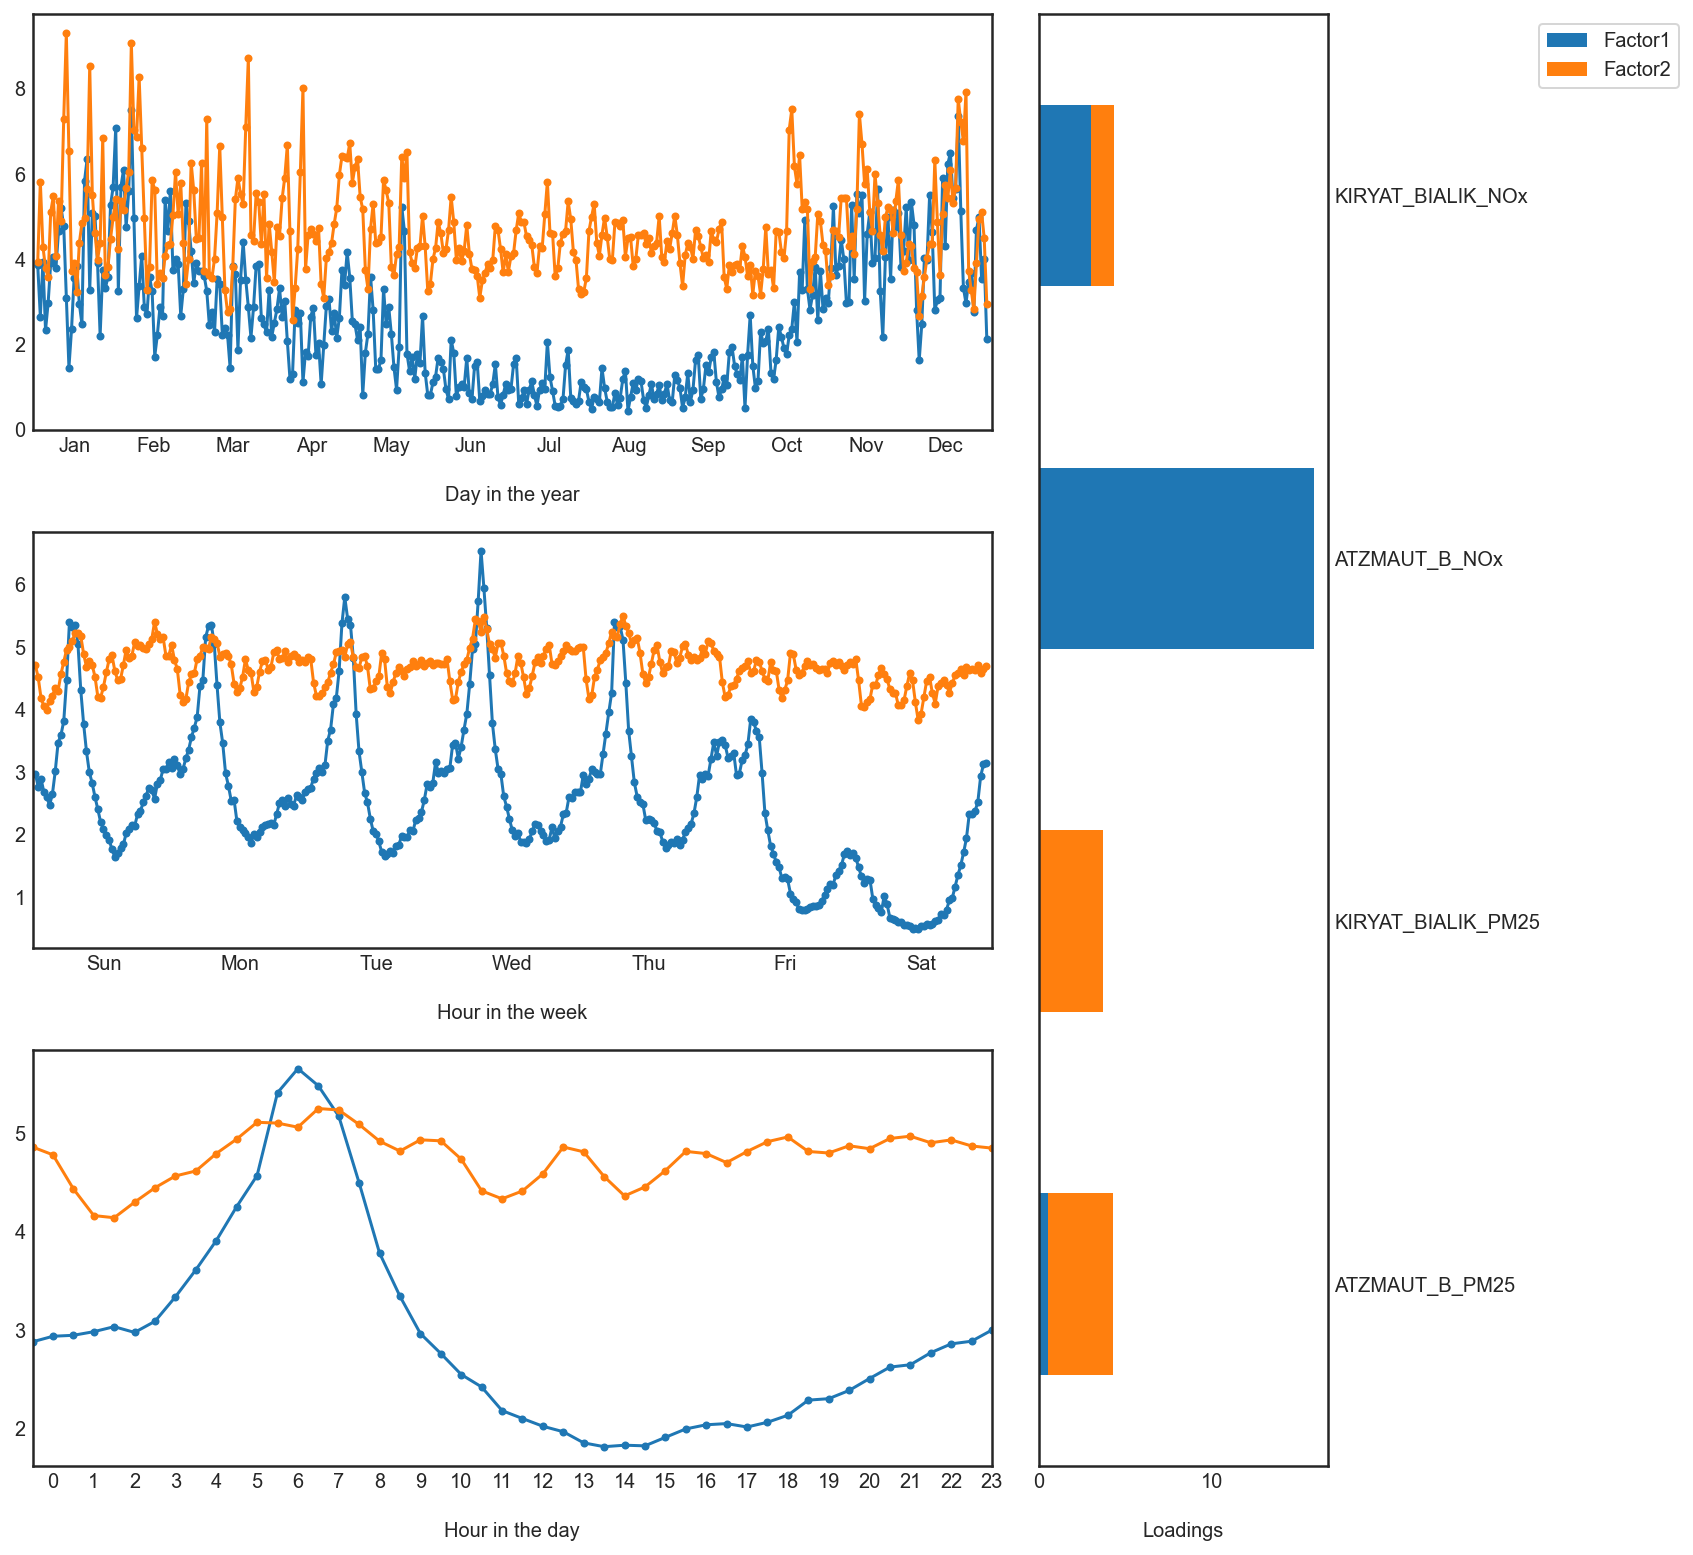

In [472]:
df_scores = add_group_columns_to_df_scores(df_scores,times)
to_save = False
plot_factors_and_loadings(df_scores, df_load, list_of_factors, column_names, weekend_removed, to_save)

In [473]:
Z0 = np.dot(df_scores.iloc[:,0],np.transpose(df_load.iloc[np.argwhere(df.columns=='ATZMAUT_B_PM25')[0][0],0]))
Z1 = np.dot(df_scores.iloc[:,1],np.transpose(df_load.iloc[np.argwhere(df.columns=='ATZMAUT_B_PM25')[0][0],1]))

In [474]:
Z0.mean()

1.364250161057919

In [475]:
Z1

array([11.12522029,  6.84647859,  8.84191874, ..., 26.18601314,
       26.42418361, 11.70546842])

In [476]:
%matplotlib inline

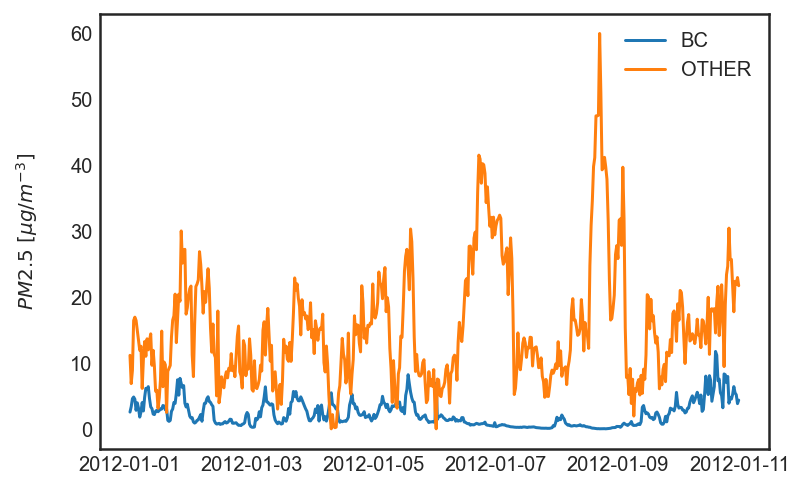

In [477]:
# BC in ATZMAUT_B_PM25 signal = 'Blue'
plt.plot(Z0[:500])
plt.plot(Z1[:500])
plt.xticks(ticks = np.linspace(0,500,num=6), labels = pd.to_datetime(times['time']).dt.date[np.linspace(0,500,num=6)])
plt.ylabel('$PM 2.5~[\mu g/m^{-3}]$\n')
plt.legend(['BC','OTHER'])
# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/factors_constructing_pm_signal.png", dpi=500)
plt.show();

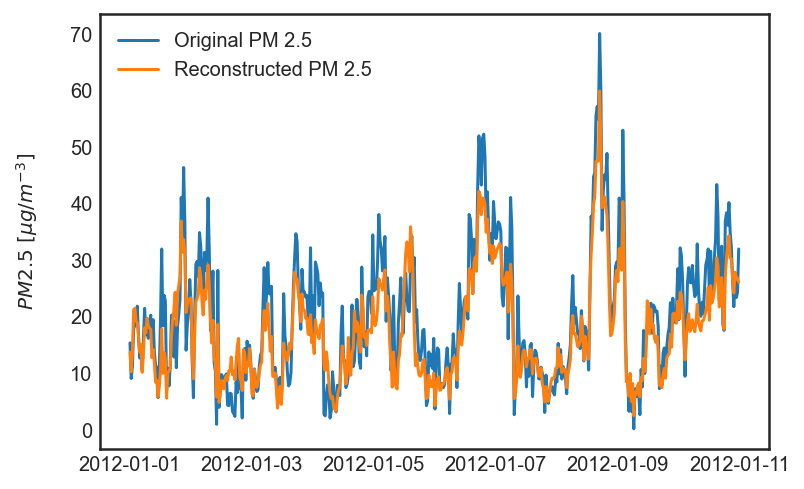

In [478]:
plt.plot(df['ATZMAUT_B_PM25'].iloc[:500].values)
plt.plot(Z0[:500]+Z1[:500]) # should be the same as the recovered X
plt.xticks(ticks = np.linspace(0,500,num=6), labels = pd.to_datetime(times['time']).dt.date[np.linspace(0,500,num=6)])
plt.ylabel('$PM 2.5~[\mu g/m^{-3}]$\n')
plt.legend(['Original PM 2.5','Reconstructed PM 2.5'])
# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/reconstracted_nmf_pm.png", dpi=500)
plt.show();

# Compare with BC

In [490]:
df_BC = pd.read_pickle('~/Documents/Broday/saved_data_from_notebooks/df_BC_NMF')

In [491]:
df_BC = df_BC['ATZMAUT_B']

In [492]:
df_BC.drop(df_BC.index[:ind_to_start],axis = 0, inplace=True)

In [493]:
# # removed 2015 storms, just to be on the same size
# df_BC.drop(df_BC.index[idx_to_drop],axis = 0, inplace=True)

In [494]:
df_BC

time
2017-01-01 00:30:00    5.2459
2017-01-01 01:00:00    6.9872
2017-01-01 01:30:00    6.2894
2017-01-01 02:00:00    7.8393
2017-01-01 02:30:00    2.1030
                        ...  
2019-12-31 21:30:00       NaN
2019-12-31 22:00:00       NaN
2019-12-31 22:30:00       NaN
2019-12-31 23:00:00       NaN
2019-12-31 23:30:00       NaN
Name: ATZMAUT_B, Length: 52559, dtype: float64

In [495]:
df_BC[~df_BC.isnull()].describe()

count    50350.000000
mean         1.993249
std          2.143541
min         -0.004400
25%          0.706800
50%          1.183400
75%          2.482150
max         41.983700
Name: ATZMAUT_B, dtype: float64

In [496]:
not_null_index = np.argwhere(~df_BC.isnull().values)

In [497]:
df_BC.shape

(52559,)

In [510]:
%matplotlib notebook

<IPython.core.display.Javascript object>


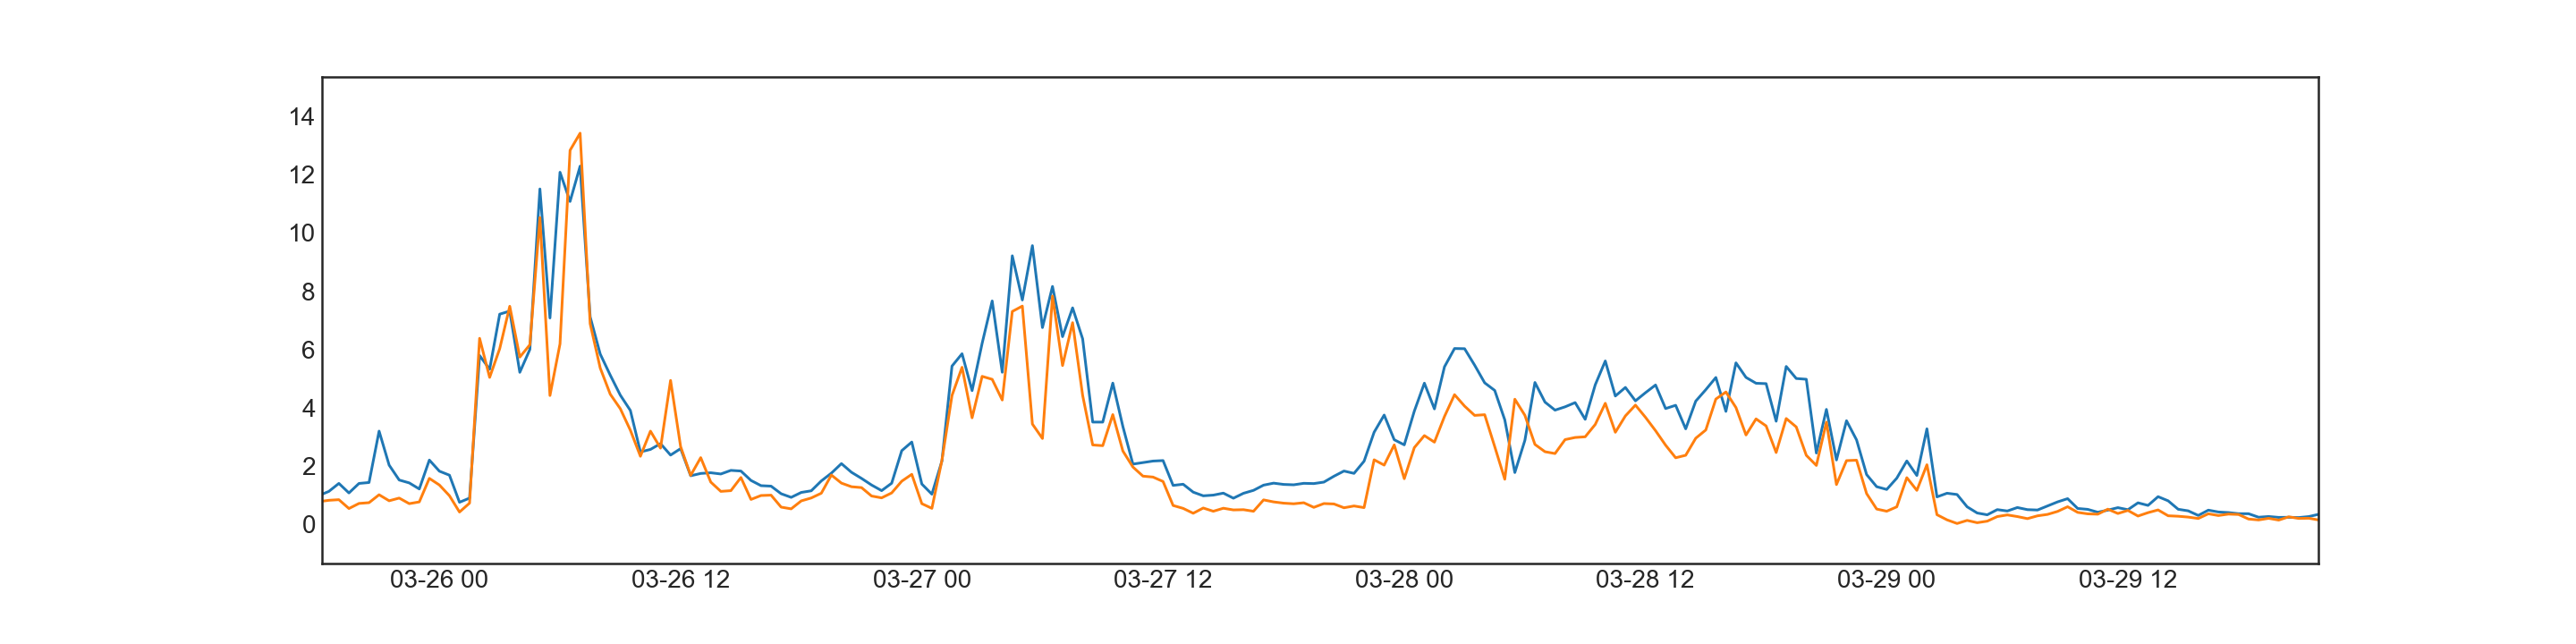

In [511]:
ax, fig = plt.subplots(figsize = (20,5))
plt.plot(df_BC[~df_BC.isnull()][:-1])
plt.plot(df_BC[~df_BC.isnull()].index[:-1],Z0[not_null_index].ravel()[1:])

In [500]:
df_BC[~df_BC.isnull()].shape

(50350,)

In [501]:
Z0[not_null_index].ravel().shape

(50350,)

In [502]:
from scipy import stats

In [503]:
np.corrcoef(df_BC[~df_BC.isnull()][:-1],Z0[not_null_index].ravel()[1:])

array([[1.        , 0.86533123],
       [0.86533123, 1.        ]])

In [504]:
stats.spearmanr(df_BC[~df_BC.isnull()][:-1],Z0[not_null_index].ravel()[1:])

SpearmanrResult(correlation=0.8551877560013291, pvalue=0.0)

In [505]:
%matplotlib inline

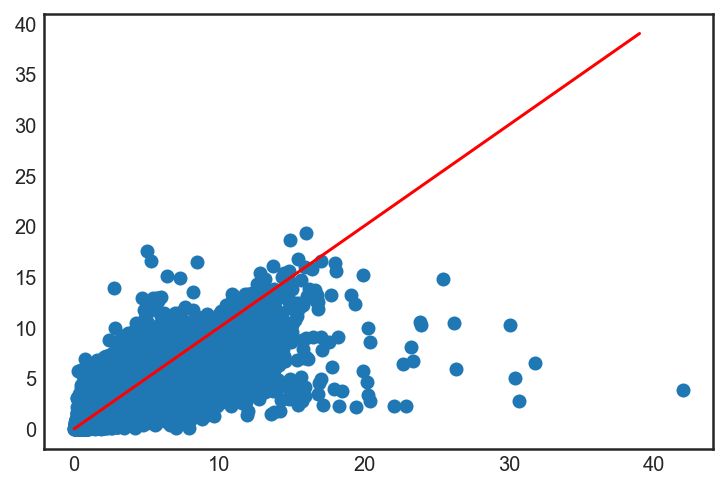

In [506]:
plt.scatter(df_BC[~df_BC.isnull()][:-1],Z0[not_null_index].ravel()[1:])
plt.plot(np.arange(0,40),np.arange(0,40),'r')

In [507]:
%matplotlib notebook

<IPython.core.display.Javascript object>


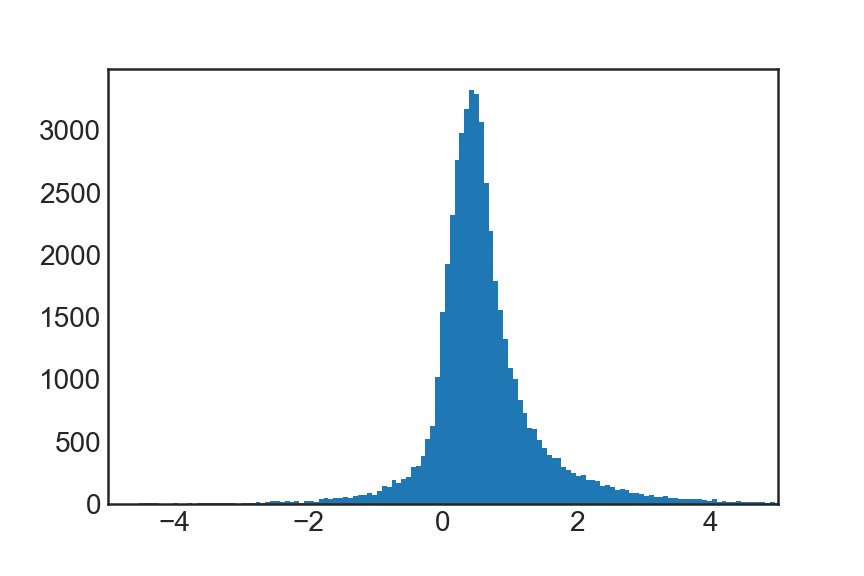

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

(-5.0, 5.0)

In [509]:
plt.hist(df_BC[~df_BC.isnull()][:-1]-Z0[not_null_index].ravel()[1:],bins=700);
plt.xlim(-5,5)